In [8]:
import yfinance as yf
import numpy as np

from scipy.stats import norm
import matplotlib.pyplot as plt


ticker = 'AAPL'
data = yf.download(ticker, start="2023-11-01", end="2024-11-01")

data['Returns'] = data['Adj Close'].pct_change()
historical_volatility = np.std(data['Returns'].dropna()) * np.sqrt(252)  
historical_drift = np.mean(data['Returns'].dropna()) * 252  

print(f"Estimated Annual Volatility: {historical_volatility}")
print(f"Estimated Annual Drift: {historical_drift}")


[*********************100%***********************]  1 of 1 completed

Estimated Annual Volatility: 0.22576459499922463
Estimated Annual Drift: 0.2929140984622724


In [9]:
def black_scholes_greeks(S0, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
        delta = -norm.cdf(-d1)
    gamma = norm.pdf(d1) / (S0 * sigma * np.sqrt(T))
    vega = S0 * norm.pdf(d1) * np.sqrt(T)
    return {"Price": price, "Delta": delta, "Gamma": gamma, "Vega": vega}

def monte_carlo_option_price(S0, K, T, r, sigma, simulations=10000, option_type='call'):
    dt = T
    discount_factor = np.exp(-r * T)
    Z = np.random.standard_normal(simulations)
    price_end = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z)
    if option_type == 'call':
        payoffs = np.maximum(price_end - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - price_end, 0)
    return discount_factor * np.mean(payoffs)


In [10]:
def dynamic_hedging_simulation(S0, K, T, r, sigma, steps=100, option_type='call'):
    dt = T / steps
    prices = [S0]
    cash_position = 0
    portfolio_value = 0
    current_stock_position = 0
    for step in range(steps):
        Z = np.random.standard_normal()
        S_t = prices[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        prices.append(S_t)
        remaining_time = T - step * dt
        delta = black_scholes_greeks(S_t, K, remaining_time, r, sigma, option_type=option_type)['Delta']
        stock_change = delta - current_stock_position
        cash_position -= stock_change * S_t
        current_stock_position = delta
        portfolio_value = cash_position + current_stock_position * S_t
    if option_type == 'call':
        option_payoff = max(prices[-1] - K, 0)
    elif option_type == 'put':
        option_payoff = max(K - prices[-1], 0)
    final_portfolio_value = portfolio_value - option_payoff
    return final_portfolio_value, prices

def calculate_var(S0, K, T, r, sigma, steps=100, simulations=1000, confidence_level=0.95):
    final_values = []
    for _ in range(simulations):
        final_value, _ = dynamic_hedging_simulation(S0, K, T, r, sigma, steps, option_type='call')
        final_values.append(final_value)
    VaR = -np.percentile(final_values, (1 - confidence_level) * 100)
    return VaR, final_values


In [11]:

S0 = data['Adj Close'][-1]  
K = S0 * 1.1  
T = 1         
r = historical_drift
sigma = historical_volatility


call_price_bs = black_scholes_greeks(S0, K, T, r, sigma, option_type='call')['Price']
call_price_mc = monte_carlo_option_price(S0, K, T, r, sigma, simulations=100000, option_type='call')


VaR_95, final_portfolio_values = calculate_var(S0, K, T, r, sigma, steps=252, simulations=1000, confidence_level=0.95)


print("Black-Scholes Call Price (Real Market Data):", call_price_bs)
print("Monte Carlo Call Price (Real Market Data):", call_price_mc)
print("95% Value at Risk (VaR):", VaR_95)


Black-Scholes Call Price (Real Market Data): 45.34256676487627
Monte Carlo Call Price (Real Market Data): 45.26441142410353
95% Value at Risk (VaR): 23.357854973920247


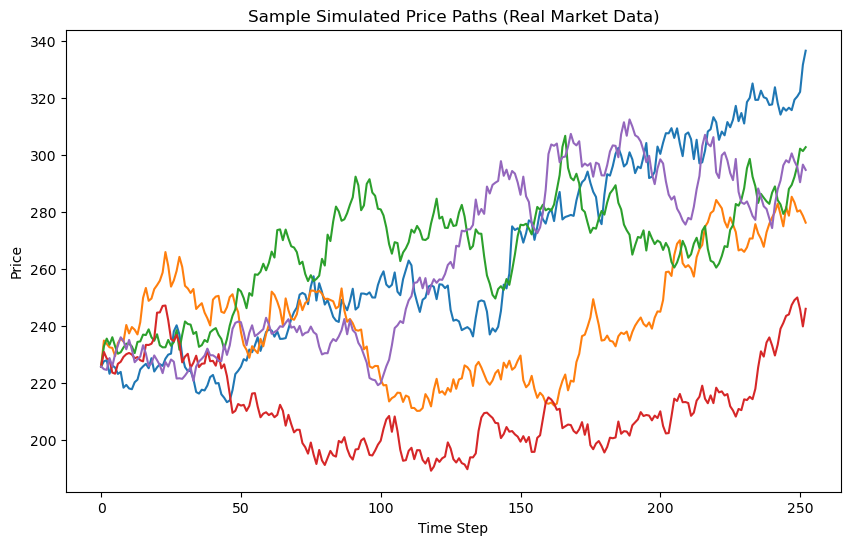

In [12]:

plt.figure(figsize=(10, 6))
for _ in range(5):
    _, price_path = dynamic_hedging_simulation(S0, K, T, r, sigma, steps=252, option_type='call')
    plt.plot(price_path)
plt.title("Sample Simulated Price Paths (Real Market Data)")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.show()


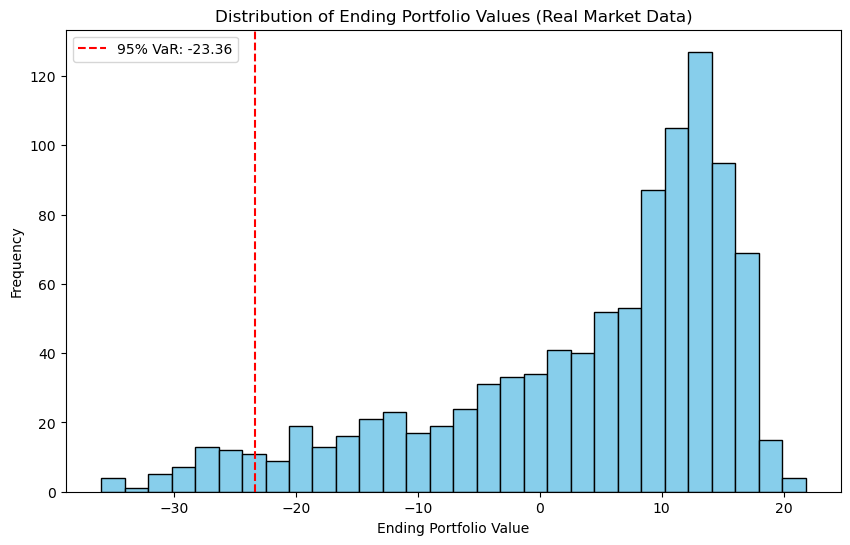

In [13]:


plt.figure(figsize=(10, 6))
plt.hist(final_portfolio_values, bins=30, color='skyblue', edgecolor='black')
plt.axvline(-VaR_95, color='red', linestyle='--', label=f"95% VaR: {-VaR_95:.2f}")
plt.title("Distribution of Ending Portfolio Values (Real Market Data)")
plt.xlabel("Ending Portfolio Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()
